# **Pretraining MLFFNN for classification**

Assignment 2 **Task 1**  |  Notebook by **Group 19**

In this notebook, we demonstrate pretraining of an MLFFNN, first by performing PCA on given features and then by using a stacked Autoencoder (2 layers). For comparison, model performance with unprocessed data has also been shown. 

In [17]:
# Dependencies
import os
import numpy as np
import pandas as pd 
from glob import glob
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm
%matplotlib notebook

## Loading data
In this section, the images and corresponding labels are loaded as numpy arrays (flattened to 1 dimension).

In [2]:
# Function to load files and generate torch data loaders

def get_data(root_path, ext='jpg_color_edh_entropy'):
    
    """Loads images and labels from dir into lists"""
    
    main_data, labels = [], []
    
    for f in os.listdir(root_path):
        paths = glob(root_path + '/' + f + '/*.' + ext)
        for path in tqdm(paths):
            vals = pd.read_csv(path, sep=' ', header=None).values
            main_data.append(vals.flatten())
            labels.append(f)

    main_data, labels = np.asarray(main_data), np.asarray(labels)

    # Label encode target
    le = LabelEncoder()
    labels = le.fit_transform(labels)
    
    return main_data, labels


def get_data_loaders(features, target, test_split=0.2):
    
    """Generates torch dataloaders for training and test data"""
    
    if test_split is not None:
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_split, shuffle=True)
        X_train, X_test = torch.from_numpy(X_train), torch.from_numpy(X_test)
        y_train, y_test = torch.from_numpy(y_train), torch.from_numpy(y_test)

        d_train = torch.utils.data.TensorDataset(X_train, y_train)
        d_test = torch.utils.data.TensorDataset(X_test, y_test)

        train_loader = torch.utils.data.DataLoader(d_train, batch_size=64, shuffle=True)
        test_loader = torch.utils.data.DataLoader(d_test, batch_size=64, shuffle=True)
        
        return train_loader, test_loader
    
    else:
        X, y = torch.from_numpy(features), torch.from_numpy(target)
        dataset = torch.utils.data.TensorDataset(X, y)
        loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
        
        return loader
    
    
# Get all data
all_data, labels = get_data('../data/data1')

100%|██████████| 410/410 [00:03<00:00, 132.14it/s]


## Visualization
In this section, we reduce the dimensionality of the data and transform it using t-SNE to observe their spatial orientation. Through this, we will get an idea of class separability and how good we can expect the models to perform. 

<IPython.core.display.Javascript object>


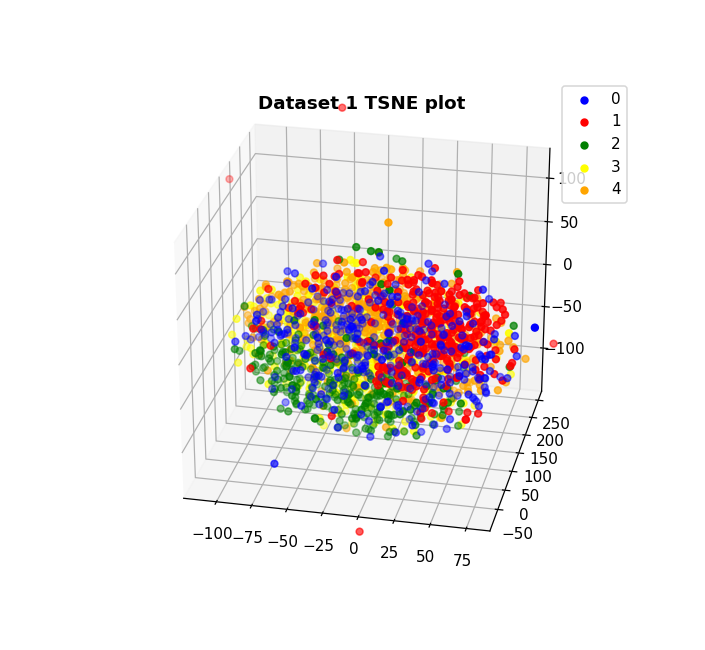

In [20]:
# TSNE reduction
tsne = TSNE(n_components=3)
data_tsne = tsne.fit_transform(all_data)
x, y, z = data_tsne[:, 0], data_tsne[:, 1], data_tsne[:, 2]

# Convert to a dataframe for easy plotting with seaborn
l_0 = np.where(labels == 0)[0]
l_1 = np.where(labels == 1)[0]
l_2 = np.where(labels == 2)[0]
l_3 = np.where(labels == 3)[0]
l_4 = np.where(labels == 4)[0]

x_0, y_0, z_0 = x[l_0], y[l_0], z[l_0]
x_1, y_1, z_1 = x[l_1], y[l_1], z[l_1]
x_2, y_2, z_2 = x[l_2], y[l_2], z[l_2]
x_3, y_3, z_3 = x[l_3], y[l_3], z[l_3]
x_4, y_4, z_4 = x[l_4], y[l_4], z[l_4]

# Plot 
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_0, y_0, z_0, zdir='z', s=20, c='blue', depthshade=True, label='0')
ax.scatter(x_1, y_1, z_1, zdir='z', s=20, c='red', depthshade=True, label='1')
ax.scatter(x_2, y_2, z_2, zdir='z', s=20, c='green', depthshade=True, label='2')
ax.scatter(x_3, y_3, z_3, zdir='z', s=20, c='yellow', depthshade=True, label='3')
ax.scatter(x_4, y_4, z_4, zdir='z', s=20, c='orange', depthshade=True, label='4')
ax.legend()
plt.title('Dataset 1 TSNE plot', fontweight='bold')
plt.show()

## Runtime functions
Here we define functions for training and evaluation of the model's progress. First, we define functions for classifier networks with Nonlinear Logloss (NLL Loss). Then we define functions for regression networks with Mean Squared Error (MSE) Loss. These will be used for configuring encoder-decoder models. 

In [3]:
# Training function

def train_clf(model, train_loader, optimizer, epoch):
    # Set model in training mode
    model.train()  
    # List to store loss values for each batch
    loss_history = []
    correct = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Initialize optimizer
        optimizer.zero_grad()
        # Generate predictions using model
        output = model(data.float())
        # Compute loss (Nonlinear logloss)
        loss = F.nll_loss(output, target)
        # Append value of loss to loss_history list
        loss_history.append(loss.item())
        # Backpropagate loss to improve model parameters
        loss.backward()
        # Find number of correct predictions
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        # Update optimizer parameters
        optimizer.step()
    
    accuracy = 100*correct/len(train_loader.dataset)
    
    return np.array(loss_history).mean(), accuracy
        
    
# Test function

def test_clf(model, test_loader, epoch, log_freq=10):
    # Set model in evaluation mode
    # Model paramters do not change when in this state
    model.eval()
    # Counters for overall loss and correct classifications for test data
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Generate model predictions
            output = model(data.float())
            # Compute loss value (sum over all examples) and update test_loss 
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            # Find prediction index
            pred = output.argmax(dim=1, keepdim=True)
            # Transform target into one-hot vector and find number of correct classifications
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    # Average test loss over test data
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100.*correct/len(test_loader.dataset)
    
    # Console ouptut
    if epoch % log_freq == 0:
        print("Test {} : Average loss: {:.4f} \t Accuracy: {}/{} ({:.2f}%)".format(
            epoch, test_loss, correct, len(test_loader.dataset), test_accuracy
        ))
        
    return test_loss, test_accuracy 

# ====================================================================================
# Train and test functions for regression networks
# These will be used to track reconstruction loss for encoder-decoder networks
# ====================================================================================

# Training function

def train_reg(model, train_loader, optimizer, epoch):
    # Set model in training mode (parameter updates valid)
    model.train()
    # List to store total loss for each batch
    loss_history = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Initialize optimizer
        optimizer.zero_grad()
        # Generate model predictions
        output = model(data.float())
        # Calculate MSE loss
        loss = F.mse_loss(output.float(), target.float())
        loss_history.append(loss.item())
        # Backpropagate loss
        loss.backward()
        # Update optimizer parameters
        optimizer.step()
    
    return np.array(loss_history).mean()
        
    
# Test function

def test_reg(model, test_loader, epoch, log_freq=10):
    # Set model in evaluation mode (no parameter updates)
    model.eval()
    # Loss counter for test data
    test_loss = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            # Generate model predictions
            output = model(data.float())
            # Compute MSE loss and update test_loss
            test_loss += F.mse_loss(output.float(), target.float(), reduction='mean').item()
            
    # Average test loss over test data
    test_loss /= len(test_loader.dataset)
    
    # Console output
    if epoch % log_freq == 0:
        print("Test {} : Average loss: {:.4f}".format(
            epoch, test_loss
        ))
        
    return test_loss

## (Test 0) Unprocessed data
No dimensionality reduction is performed here. 

Test 0 : Average loss: 1.5322 	 Accuracy: 102/356 (28.65%)
Test 10 : Average loss: 1.0872 	 Accuracy: 202/356 (56.74%)
Test 20 : Average loss: 1.0058 	 Accuracy: 229/356 (64.33%)
Test 30 : Average loss: 0.9887 	 Accuracy: 230/356 (64.61%)
Test 40 : Average loss: 0.9829 	 Accuracy: 233/356 (65.45%)
Test 50 : Average loss: 0.9822 	 Accuracy: 233/356 (65.45%)
Test 60 : Average loss: 0.9817 	 Accuracy: 234/356 (65.73%)
Test 70 : Average loss: 0.9813 	 Accuracy: 233/356 (65.45%)
Test 80 : Average loss: 0.9814 	 Accuracy: 233/356 (65.45%)
Test 90 : Average loss: 0.9812 	 Accuracy: 233/356 (65.45%)


<IPython.core.display.Javascript object>


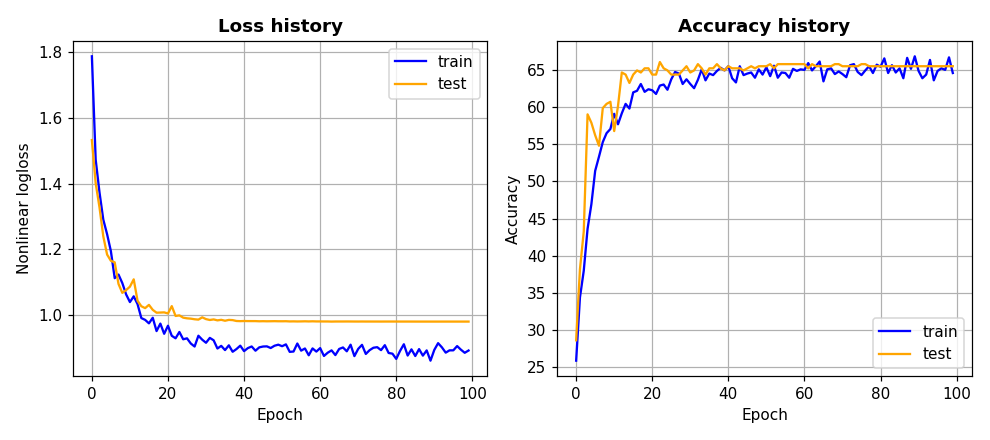

Final training loss: 0.8934
Final training accuracy: 64.5365
Final validation loss: 0.9812
Final validation accuracy: 65.4494


In [5]:
# Network for unselected features

class Net(torch.nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.dense1 = torch.nn.Linear(828, 150)
        self.dense2 = torch.nn.Linear(150, 5)
        self.dropout1 = torch.nn.Dropout(0.25)
        
    def forward(self, x):
        """Forward pass"""
        x = self.dense1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        out = F.log_softmax(x, dim=1)
        return out
    
# Generate data loaders
train_loader, test_loader = get_data_loaders(all_data, labels, test_split=0.2)
    
# Training 
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
loss_func = F.nll_loss

train_loss_hist, test_loss_hist = [], []
train_accuracy_hist, test_accuracy_hist = [], []

for epoch in range(100):
    train_loss, train_accuracy = train_clf(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test_clf(model, test_loader, epoch, log_freq=10)
    scheduler.step()
    train_loss_hist.append(train_loss)
    train_accuracy_hist.append(train_accuracy)
    test_loss_hist.append(test_loss)
    test_accuracy_hist.append(test_accuracy)
    
    
# Plots of loss and accuracy
fig = plt.figure(figsize=(9, 4))

# Loss plots
ax1 = fig.add_subplot(121)
ax1.plot(train_loss_hist, color='blue', label='train')
ax1.plot(test_loss_hist, color='orange', label='test')
ax1.set_title('Loss history', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Nonlinear logloss')
ax1.grid()
ax1.legend()

# Accuracy plots
ax2 = fig.add_subplot(122)
ax2.plot(train_accuracy_hist, color='blue', label='train')
ax2.plot(test_accuracy_hist, color='orange', label='test')
ax2.set_title('Accuracy history', fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

# Final training and validation accuracy
print("Final training loss: {:.4f}".format(train_loss_hist[-1]))
print("Final training accuracy: {:.4f}".format(train_accuracy_hist[-1]))
print("Final validation loss: {:.4f}".format(test_loss_hist[-1]))
print("Final validation accuracy: {:.4f}".format(test_accuracy_hist[-1]))

## (Test 1) Principal Component Analysis
The dimensionality of the data is reduced using PCA and we train on those new features. To determine the final dimensionality of the data, we perform a cumulative sum on the explained variances starting from 1 dimension to the dimension of the original data. The final dimensionality is the point where sum of explained variances plateaus off. For our case, this turns out to be 200.

<IPython.core.display.Javascript object>


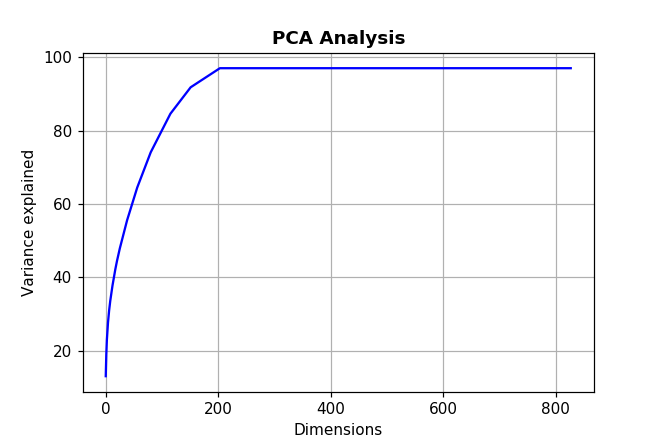

In [7]:
# Determining how many dimensions to retrain
pca = PCA()
pca.fit(all_data)

# Perform cumulative sum of explained variances 
var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100.0)

# Plot cumulative sum 
plt.figure(figsize=(6, 4))
plt.plot(var, color='blue')
plt.xlabel('Dimensions')
plt.ylabel('Variance explained')
plt.title('PCA Analysis', fontweight='bold')
plt.grid()
plt.show()

# Create new data loaders with 200 features
pca = PCA(n_components=200)
data_pca = pca.fit_transform(all_data)

Test 0 : Average loss: 1.3933 	 Accuracy: 162/356 (45.51%)
Test 10 : Average loss: 0.7926 	 Accuracy: 252/356 (70.79%)
Test 20 : Average loss: 0.7974 	 Accuracy: 253/356 (71.07%)
Test 30 : Average loss: 0.8084 	 Accuracy: 256/356 (71.91%)
Test 40 : Average loss: 0.8112 	 Accuracy: 256/356 (71.91%)
Test 50 : Average loss: 0.8124 	 Accuracy: 256/356 (71.91%)
Test 60 : Average loss: 0.8129 	 Accuracy: 257/356 (72.19%)
Test 70 : Average loss: 0.8131 	 Accuracy: 257/356 (72.19%)
Test 80 : Average loss: 0.8132 	 Accuracy: 257/356 (72.19%)
Test 90 : Average loss: 0.8132 	 Accuracy: 257/356 (72.19%)


<IPython.core.display.Javascript object>


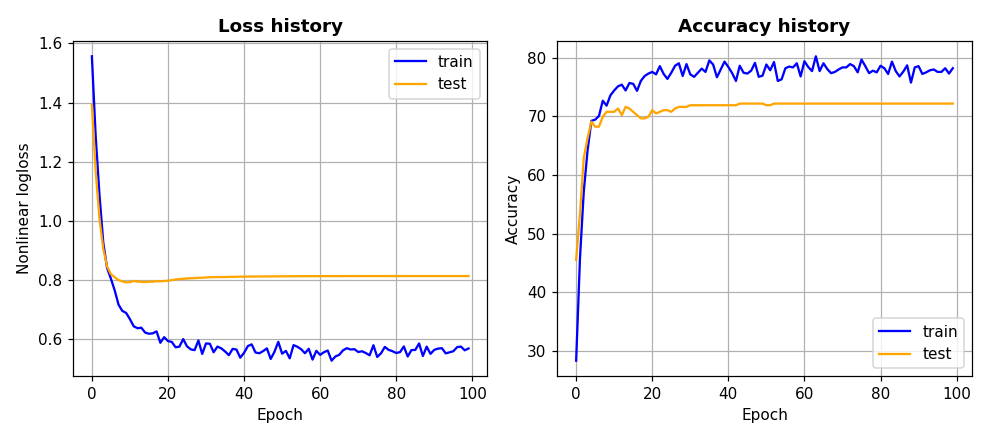

Final training loss: 0.5682
Final training accuracy: 78.2303
Final validation loss: 0.8132
Final validation accuracy: 72.1910


In [8]:
# Define network

class PCANet(torch.nn.Module):
    
    def __init__(self):
        super(PCANet, self).__init__()
        self.dense1 = torch.nn.Linear(200, 10)
        self.dense2 = torch.nn.Linear(10, 5)
        self.dropout1 = torch.nn.Dropout(0.25)
        
    def forward(self, x):
        """Forward pass"""
        x = self.dense1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        out = F.log_softmax(x, dim=1)
        return out
    
# Data loaders
train_loader, test_loader = get_data_loaders(data_pca, labels, test_split=0.2)

# Training
model = PCANet()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
loss_func = F.nll_loss

train_loss_hist, test_loss_hist = [], []
train_accuracy_hist, test_accuracy_hist = [], []

for epoch in range(100):
    train_loss, train_accuracy = train_clf(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test_clf(model, test_loader, epoch, log_freq=10)
    scheduler.step()
    train_loss_hist.append(train_loss)
    train_accuracy_hist.append(train_accuracy)
    test_loss_hist.append(test_loss)
    test_accuracy_hist.append(test_accuracy)
    

# Plots of loss and accuracy
fig = plt.figure(figsize=(9, 4))

# Loss plots
ax1 = fig.add_subplot(121)
ax1.plot(train_loss_hist, color='blue', label='train')
ax1.plot(test_loss_hist, color='orange', label='test')
ax1.set_title('Loss history', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Nonlinear logloss')
ax1.grid()
ax1.legend()

# Accuracy plots
ax2 = fig.add_subplot(122)
ax2.plot(train_accuracy_hist, color='blue', label='train')
ax2.plot(test_accuracy_hist, color='orange', label='test')
ax2.set_title('Accuracy history', fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

# Final training and validation accuracy
print("Final training loss: {:.4f}".format(train_loss_hist[-1]))
print("Final training accuracy: {:.4f}".format(train_accuracy_hist[-1]))
print("Final validation loss: {:.4f}".format(test_loss_hist[-1]))
print("Final validation accuracy: {:.4f}".format(test_accuracy_hist[-1]))

## (Test 3) Autoencoder Features
Now we will stack two encoders from trained encoder-decoder models to generate an auto-encoder for dimension reduction. We first define two encoder-decoder models with appropriate dimensions and train them separately. Then, we concatenate encoders from both and attach it prior to a classifier layer. The AANNs will reduce dimensions in the following format.

$$
(828 => 300) \quad -> \quad (300 => 200)
$$

Encoder-Decoder 1
Test 0 : Average loss: 0.0077
Test 10 : Average loss: 0.0054
Test 20 : Average loss: 0.0049
Test 30 : Average loss: 0.0046
Test 40 : Average loss: 0.0045
Test 50 : Average loss: 0.0044
Test 60 : Average loss: 0.0044
Test 70 : Average loss: 0.0044
Test 80 : Average loss: 0.0043
Test 90 : Average loss: 0.0043


<IPython.core.display.Javascript object>


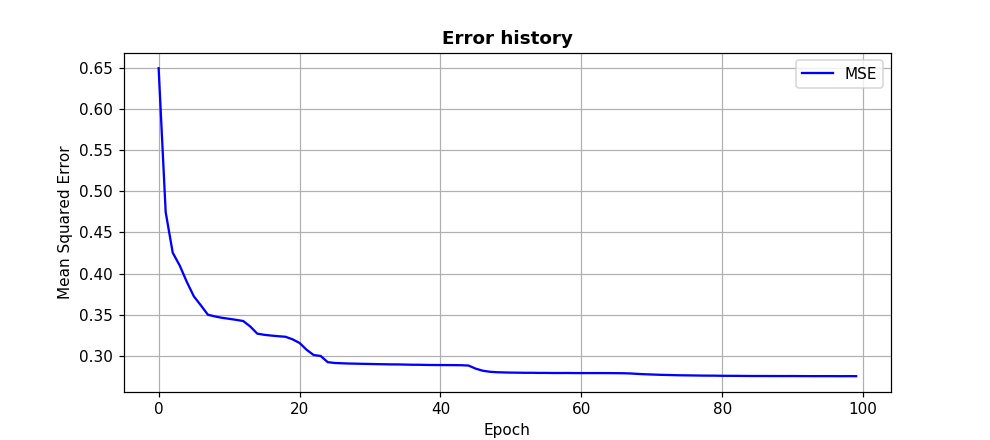


Encoder-Decoder 2
Test 0 : Average loss: 0.0030
Test 10 : Average loss: 0.0010
Test 20 : Average loss: 0.0007
Test 30 : Average loss: 0.0007
Test 40 : Average loss: 0.0007
Test 50 : Average loss: 0.0007
Test 60 : Average loss: 0.0007
Test 70 : Average loss: 0.0007
Test 80 : Average loss: 0.0007
Test 90 : Average loss: 0.0007


<IPython.core.display.Javascript object>


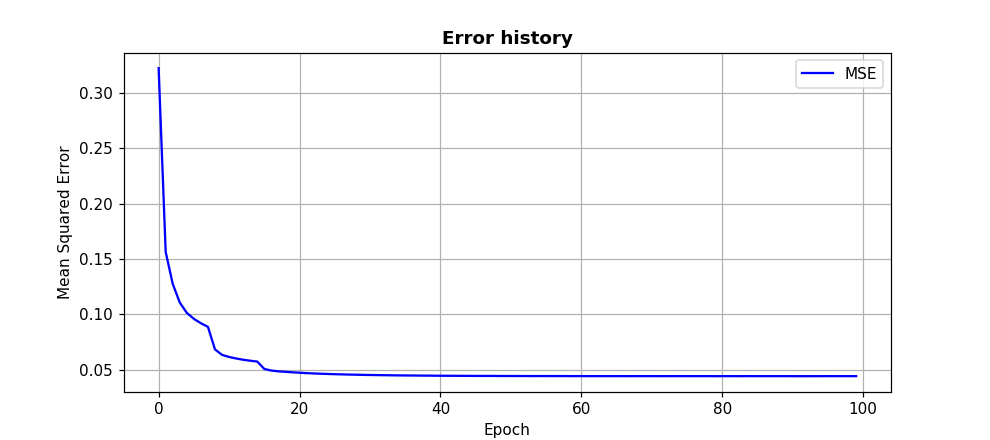

In [4]:
# Encoder-decoder network 1

class EncoderDecoder_1(torch.nn.Module):
    
    def __init__(self):
        super(EncoderDecoder_1, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(828, 300),
            torch.nn.ReLU())
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(300, 828),
            torch.nn.ReLU())
        
    def forward(self, x):
        x = self.encoder(x)
        out = self.decoder(x)
        return out

    
# Data loaders
data_loader = get_data_loaders(all_data, all_data, test_split=None)

# Training 
ed_1 = EncoderDecoder_1()
optimizer = optim.Adam(ed_1.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

train_loss_hist, test_loss_hist = [], []

print("Encoder-Decoder 1")
for epoch in range(100):
    train_loss = train_reg(ed_1, data_loader, optimizer, epoch)
    test_loss = test_reg(ed_1, data_loader, epoch, log_freq=10)
    scheduler.step()
    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)
    
latent_1 = ed_1.encoder(torch.from_numpy(all_data).float()).detach().numpy()

# Plot reconstruction error
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(111)
ax1.plot(train_loss_hist, color='blue', label='MSE')
ax1.set_title('Error history', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Squared Error')
ax1.grid()
ax1.legend()


# Encoder decoder network 2

class EncoderDecoder_2(torch.nn.Module):
    
    def __init__(self):
        super(EncoderDecoder_2, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(300, 200),
            torch.nn.ReLU())
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(200, 300),
            torch.nn.ReLU())
        
    def forward(self, x):
        x = self.encoder(x)
        out = self.decoder(x)
        return out

    
# Data loaders
data_loader = get_data_loaders(latent_1, latent_1, test_split=None)

# Training 
ed_2 = EncoderDecoder_2()
optimizer = optim.Adam(ed_2.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

train_loss_hist, test_loss_hist = [], []

print("\nEncoder-Decoder 2")
for epoch in range(100):
    train_loss = train_reg(ed_2, data_loader, optimizer, epoch)
    test_loss = test_reg(ed_2, data_loader, epoch, log_freq=10)
    scheduler.step()
    train_loss_hist.append(train_loss)
    test_loss_hist.append(test_loss)
    
    
# Combine both encoders and get latent representation
autoencoder = torch.nn.Sequential(
    ed_1.encoder,
    ed_2.encoder
)

# Plot reconstruction error
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_subplot(111)
ax1.plot(train_loss_hist, color='blue', label='MSE')
ax1.set_title('Error history', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Squared Error')
ax1.grid()
ax1.legend()

Test 0 : Average loss: 1.5722 	 Accuracy: 64/356 (17.98%)
Test 10 : Average loss: 1.0514 	 Accuracy: 217/356 (60.96%)
Test 20 : Average loss: 0.9423 	 Accuracy: 228/356 (64.04%)
Test 30 : Average loss: 0.9164 	 Accuracy: 237/356 (66.57%)
Test 40 : Average loss: 0.9159 	 Accuracy: 237/356 (66.57%)
Test 50 : Average loss: 0.9181 	 Accuracy: 238/356 (66.85%)
Test 60 : Average loss: 0.9179 	 Accuracy: 236/356 (66.29%)
Test 70 : Average loss: 0.9176 	 Accuracy: 236/356 (66.29%)
Test 80 : Average loss: 0.9173 	 Accuracy: 236/356 (66.29%)
Test 90 : Average loss: 0.9173 	 Accuracy: 236/356 (66.29%)


<IPython.core.display.Javascript object>


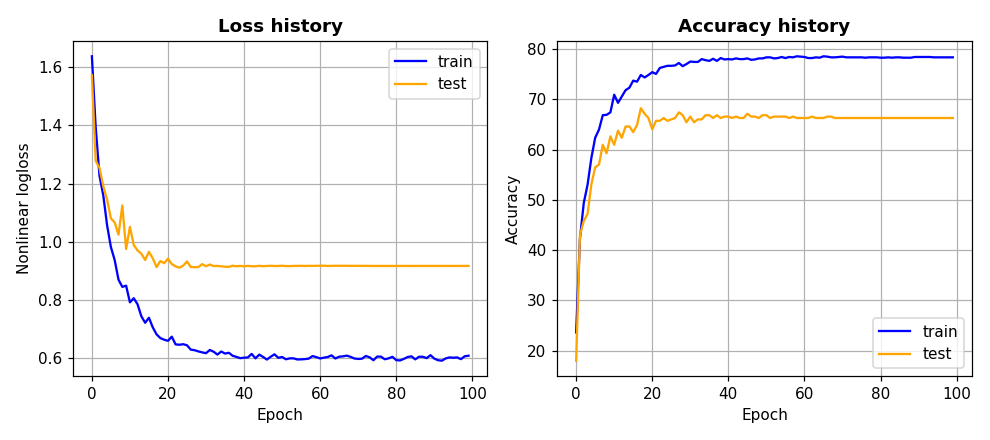

Final training loss: 0.6091
Final training accuracy: 78.3708
Final validation loss: 0.9174
Final validation accuracy: 66.2921


In [5]:
# Classifier network with autoencoder network

class AENet(torch.nn.Module):
    
    def __init__(self):
        super(AENet, self).__init__()
        self.autoencoder = autoencoder
        self.dense1 = torch.nn.Linear(200, 5)
        
    def forward(self, x):
        """Forward pass"""
        x = self.autoencoder(x)
        x = self.dense1(x)
        out = F.log_softmax(x, dim=1)
        return out
    

# Data loaders
train_loader, test_loader = get_data_loaders(all_data, labels, test_split=0.2)

# Training 
model = AENet()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

train_loss_hist, test_loss_hist = [], []
train_accuracy_hist, test_accuracy_hist = [], []

for epoch in range(100):
    train_loss, train_accuracy = train_clf(model, train_loader, optimizer, epoch)
    test_loss, test_accuracy = test_clf(model, test_loader, epoch, log_freq=10)
    scheduler.step()
    train_loss_hist.append(train_loss)
    train_accuracy_hist.append(train_accuracy)
    test_loss_hist.append(test_loss)
    test_accuracy_hist.append(test_accuracy)
    

# Plots of loss and accuracy
fig = plt.figure(figsize=(9, 4))

# Loss plots
ax1 = fig.add_subplot(121)
ax1.plot(train_loss_hist, color='blue', label='train')
ax1.plot(test_loss_hist, color='orange', label='test')
ax1.set_title('Loss history', fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Nonlinear logloss')
ax1.grid()
ax1.legend()

# Accuracy plots
ax2 = fig.add_subplot(122)
ax2.plot(train_accuracy_hist, color='blue', label='train')
ax2.plot(test_accuracy_hist, color='orange', label='test')
ax2.set_title('Accuracy history', fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()

# Final training and validation accuracy
print("Final training loss: {:.4f}".format(train_loss_hist[-1]))
print("Final training accuracy: {:.4f}".format(train_accuracy_hist[-1]))
print("Final validation loss: {:.4f}".format(test_loss_hist[-1]))
print("Final validation accuracy: {:.4f}".format(test_accuracy_hist[-1]))

## Conclusions

From the three experiments, here is what we have inferred.

1. Of the three methods, PCA has provided best model performance. However, the numbers vary (ever so) slightly from run to run. 
2. Using PCA reduced features gave a slight boost to accuracy but might have caused some amount of overfitting, as is visible from loss trends.
2. Using a stacked autoencoder resulted in a small drop in accuracy, along with possibility of overfitting. This might be due to small size of our dataset compared to the number of model parameters to be trained. Thinning the encoder-decoder networks might help in improving this problem.
